Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.
Epoch 1/10
782/782 [==============================] - 16s 20ms/step - loss: 0.6498 - binary_accuracy: 0.7030 - val_loss: 0.5858 - val_binary_accuracy: 0.7836
Epoch 2/10
782/782 [==============================] - 2s 3ms/step - loss: 0.5091 - binary_accuracy: 0.8175 - val_loss: 0.4620 - val_binary_accuracy: 0.8344
Epoch 3/10
782/782 [==============================] - 2s 3ms/step - loss: 0.4034 - binary_accuracy: 0.8598 - val_loss: 0.3943 - val_binary_accuracy: 0.8484
Epoch 4/10
782/782 [==============================] - 2s 3ms/step - loss: 0.3424 - binary_accuracy: 0.8772 - val_loss: 0.3587 - val_binary_accuracy: 0.8572
Epoch 5/10
782/782 [==============================] - 2s 3ms/step - loss: 0.3042 - binary_accuracy: 0.8896 - val_loss: 0.3389 - val_binary_accuracy: 0.8614
Epoch 6/10
782/782 [=======

array([[0.66049373],
       [0.44194302],
       [0.28609145]], dtype=float32)

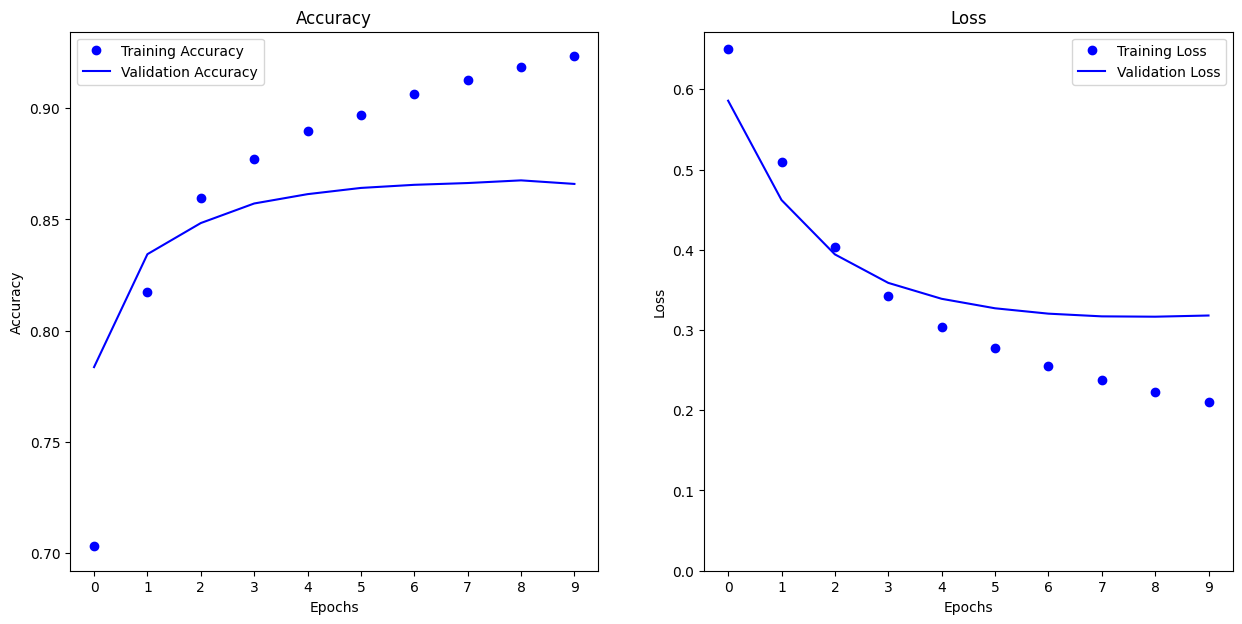

In [1]:
import tensorflow as tf
import os, re, shutil, string
import matplotlib.pyplot as plt
import numpy as np 

"""
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url, untar=True, cache_dir='.', cache_subdir='')

ds_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
train_dir = os.path.join(ds_dir, 'train')
sample_file = os.path.join(train_dir)

remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)
"""
batch_size = 32
seed = 42 
raw_train_ds = tf.keras.utils.text_dataset_from_directory( 
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed
)

raw_val_ds = tf.keras.utils.text_dataset_from_directory( 
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed
)

raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html, '[%s]' % re.escape(string.punctuation), '')

max_feat = 10000
sequence_length = 250

vectorize_layer = tf.keras.layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_feat,
    output_mode='int',
    output_sequence_length=sequence_length
    )
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

train_ds=raw_test_ds.map(vectorize_text)
val_ds=raw_val_ds.map(vectorize_text)
test_ds=raw_test_ds.map(vectorize_text)

train_ds=train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

embedding_dim=16
model = tf.keras.Sequential([ 
    tf.keras.layers.Embedding(max_feat+1, embedding_dim),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

model.compile(loss=tf.losses.BinaryCrossentropy(from_logits=True), 
    optimizer='adam',
    metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

epochs=10
hist=model.fit(
    train_ds, 
    validation_data=val_ds, 
    epochs=epochs)

loss, accuracy = model.evaluate(test_ds, verbose=2)

hist_dict = hist.history

acc = hist_dict['binary_accuracy']
val_acc = hist_dict['val_binary_accuracy']
loss = hist_dict['loss']
val_loss = hist_dict['val_loss']
epochs_range=range(epochs)
def make_plot():
    plt.figure(figsize=(15,7))
    plt.subplot(1, 2, 1)
    plt.title("Accuracy")
    plt.plot(epochs_range, acc, 'bo', label='Training Accuracy')
    plt.plot(epochs_range, val_acc, 'b', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xticks(range(10))
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.title("Loss")
    plt.plot(epochs_range, loss, 'bo', label='Training Loss')
    plt.plot(epochs_range, val_loss, 'b', label='Validation Loss')
    plt.ylim(0)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xticks(range(10))
    #plt.yticks(np.arange(0, 1, 0.1))
    plt.legend()
make_plot()

export_model = tf.keras.Sequential([
    vectorize_layer,
    model,
    tf.keras.layers.Activation('sigmoid')
])

export_model.compile(loss=tf.losses.BinaryCrossentropy(from_logits=False), optimizer='adam',
    metrics=['accuracy'])

loss, accuracy = export_model.evaluate(raw_test_ds, verbose=2)

examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

export_model.predict(examples)